In [33]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
options(repr.matrix.max.rows = 8)

set.seed(8205)

 # Reading in Heart Disease Data

In [34]:

#download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data",
            #  destfile = "./switzerland_data.data")

#read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/switzerland.data/processed.switzerland.data")

cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE) |>
    rename(age      = X1,      # Age in years
           sex      = X2,      # Sex (1 = male, 0 = female)
           cp       = X3,      # Chest pain type 
                               # - 1 : typical angina
                               # - 2 : atypical angina
                               # - 3 : non-anginal pain
                               # - 4 : asymptomatic
           trestbps = X4,      # Resting blood pressure (mmHg)
           chol     = X5,      # Serum cholestoral (mg/dL)
           fbs      = X6,      # Fasting blood sugar > 120 mg/dL (1 = true, 0 = false)
           restecg  = X7,      # Resting electrocardiographic results 
                               # - 0 : normal,
                               # - 1 : having ST-T wave abnormality (T wave inversions and/or ST 
                               #       elevation or depression of > 0.05 mV)
                               # - 2 : showing probable or definite left ventricular hypertrophy by Estes' criteria
           thalach  = X8,      # Maximum heart rate achieved
           exang    = X9,      # Exercise induced angina (0 = no, 1 = yes)
           oldpeak  = X10,     # ST depression induced by exercise relative to rest
           slope    = X11,     # The slope of the peak exercise ST segment
                               # - 1 : upsloping
                               # - 2 : flat
                               # - 3 : downsloping
           ca       = X12,     # Number of major vessels (0-3) colored by flourosopy
           thal     = X13,     # 3 = normal; 6 = fixed defect; 7 = reversable defect
           num      = X14)     # diagnosis of heart disease (angiographic disease status)

cleveland_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


# Data wrangling

In [35]:
#Convert columns to sensible data types
cleveland_data <- cleveland_data |>
    mutate(age      = as.integer(age),
           sex      = as.factor(sex),
           cp       = as.factor(cp),
           trestbps = as.integer(trestbps),
           chol     = as.integer(chol),
           fbs      = as.factor(fbs),
           restecg  = as.factor(restecg),
           thalach  = as.integer(thalach),
           exang    = as.factor(exang),
           oldpeak  = as.double(oldpeak),
           slope    = as.factor(slope),
           ca       = as.integer(ca),
           thal     = as.factor(thal),
           num      = as.factor(num)) 

# Creating a new column which is whether or not a person has presence of heart disease
cleveland_data <- cleveland_data |>
    mutate(presence = (num != 0)) |>    
    mutate(presence = as.factor(presence))


cleveland_data

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,presence
<int>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<int>,<fct>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6.0,0,FALSE
67,1,4,160,286,0,2,108,1,1.5,2,3,3.0,2,TRUE
67,1,4,120,229,0,2,129,1,2.6,2,2,7.0,1,TRUE
37,1,3,130,250,0,0,187,0,3.5,3,0,3.0,0,FALSE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2,7.0,2,TRUE
57,1,4,130,131,0,0,115,1,1.2,2,1,7.0,3,TRUE
57,0,2,130,236,0,2,174,0,0.0,2,1,3.0,1,TRUE
38,1,3,138,175,0,0,173,0,0.0,1,NA,3.0,0,FALSE


In [36]:
# Splitting the data into training and testing sets
cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = num)
cleveland_training <- training(cleveland_split) 
cleveland_testing <- testing(cleveland_split)

# Exploratory data analysis

### Heart Disease Summary

In [37]:
target_summary <- cleveland_training |>
    group_by(presence) |>
    summarize(count = n())
target_summary

presence,count
<fct>,<int>
FALSE,123
TRUE,103


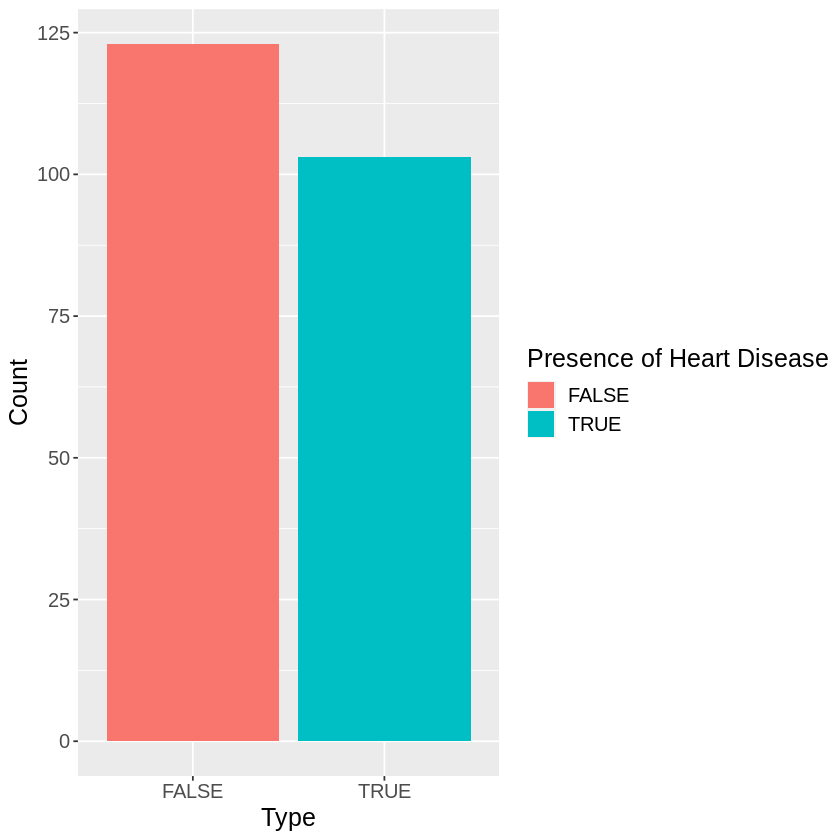

In [38]:
target_summary_plot <- target_summary |>
    ggplot(aes(x = presence, y = count, fill = presence)) +
    geom_bar(stat = "identity") +
    labs(x = "Type", y = "Count", fill = "Presence of Heart Disease") +
    theme(text = element_text(size = 15))

target_summary_plot

From the dataset, the majority of patients do not have any presence of heart disease.

### Demographics

In [39]:
demographic_summary <- cleveland_training |>
    group_by(sex) |>
    summarize(count = n(), average_age = mean(age))
demographic_summary

sex,count,average_age
<fct>,<int>,<dbl>
0,73,56.06849
1,153,53.66667


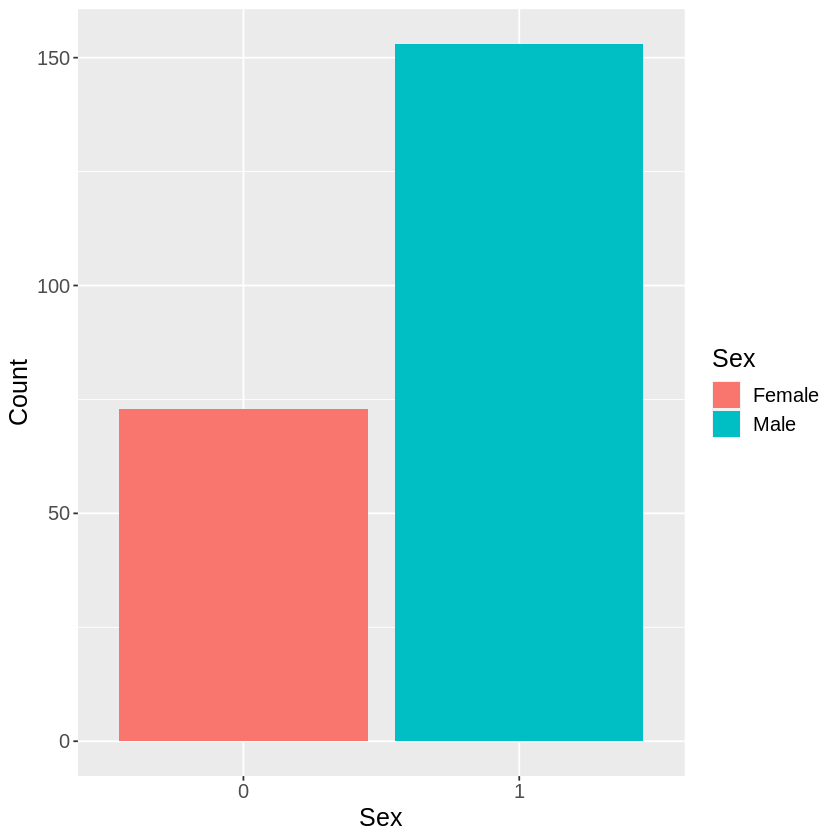

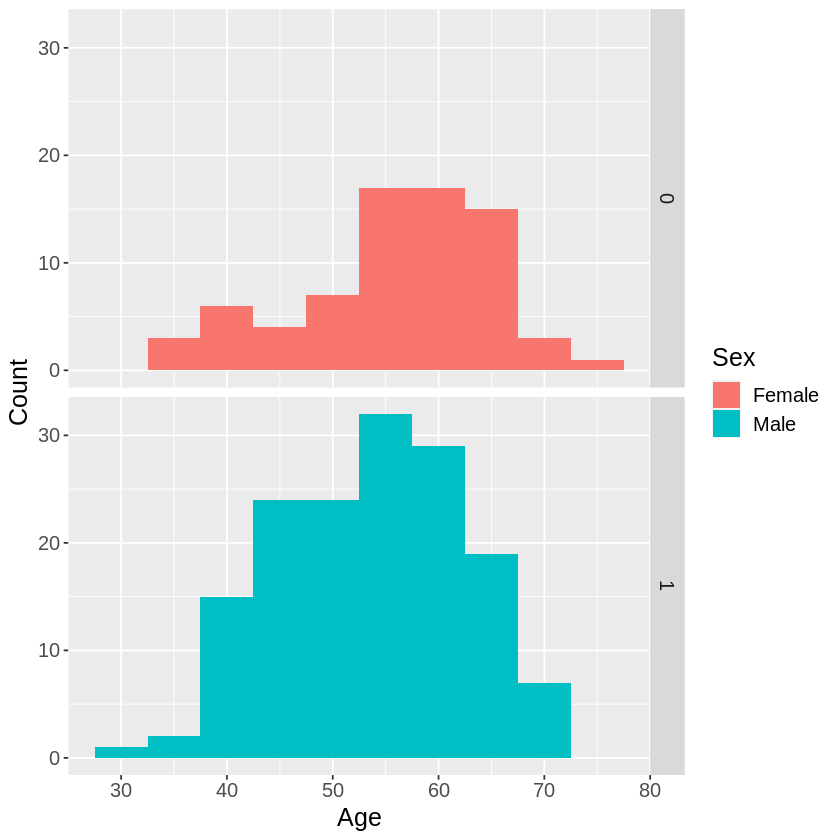

In [40]:
demographic_sex_summary_plot <- demographic_summary |>
    ggplot(aes(x =  sex, y = count, fill = sex)) +
    geom_bar(stat = "identity") +
    labs(x = "Sex", y = "Count", fill = "Sex") +
    scale_fill_discrete(labels = c("Female", "Male")) +
    theme(text = element_text(size = 15))

demographic_age_summary_plot <- cleveland_training |>
    ggplot(aes(x =  age, fill = sex)) +
    geom_histogram(binwidth = 5) +
    labs(x = "Age", y =  "Count", fill = "Sex") +
    scale_fill_discrete(labels = c("Female", "Male")) +
    facet_grid(rows = vars(sex)) +
    theme(text = element_text(size = 15))

demographic_sex_summary_plot
demographic_age_summary_plot

The number of male double that of female participants. The average age for this dataset is around 54 years old. In addition, the average age of the male is slightly younger than female participants.

### Blood Pressure

In [41]:
average_restbps <- cleveland_training |>
    summarize(average_restbps = mean(trestbps))
average_restbps

average_restbps
<dbl>
132.3319


The average resting blood pressure of all participants is 132*mmHg*. Let's see how this would affect the type of heart disease.

In [42]:
average_restbps_by_type <- cleveland_training |>
    group_by(presence) |>
    summarize(average_restbps = mean(trestbps))
average_restbps_by_type

presence,average_restbps
<fct>,<dbl>
FALSE,128.8293
TRUE,136.5146


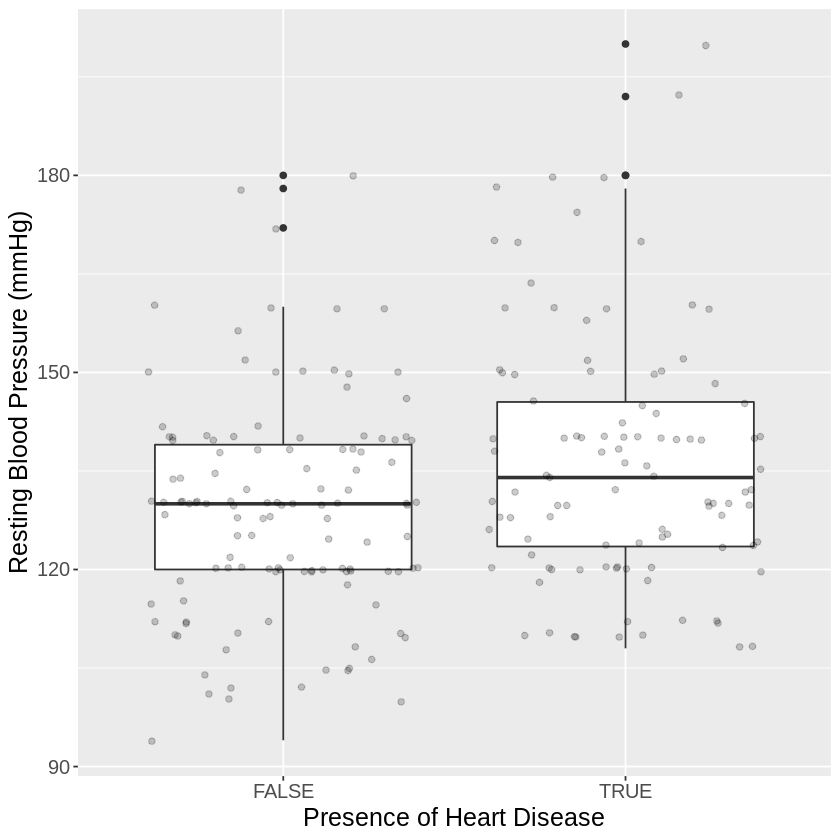

In [43]:
restbps_summary_plot <- cleveland_training |>
    ggplot(aes(x = presence, y = trestbps))+
        geom_boxplot()+
        geom_point(position = "jitter", alpha = 0.2) +
        labs(x = "Presence of Heart Disease", y = "Resting Blood Pressure (mmHg)") +
        theme(text = element_text(size = 15))

restbps_summary_plot

People with no presence of heart disease have lower average resting blood pressure. Those who do tend to have slightly higher resting blood pressure.

### Serum Cholestoral

In [44]:
average_chol <- cleveland_training |>
    summarize(average_chol = mean(chol))
average_chol

average_chol
<dbl>
248.5


The average serum cholestoral in the data set is 248.5*mg/dL*. Let's see what's the average for each type of heart disease.

In [45]:
average_chol_by_type <- cleveland_training |>
    group_by(presence) |>
    summarize(average_chol = mean(chol))
average_chol_by_type

presence,average_chol
<fct>,<dbl>
FALSE,247.1220
TRUE,250.1456


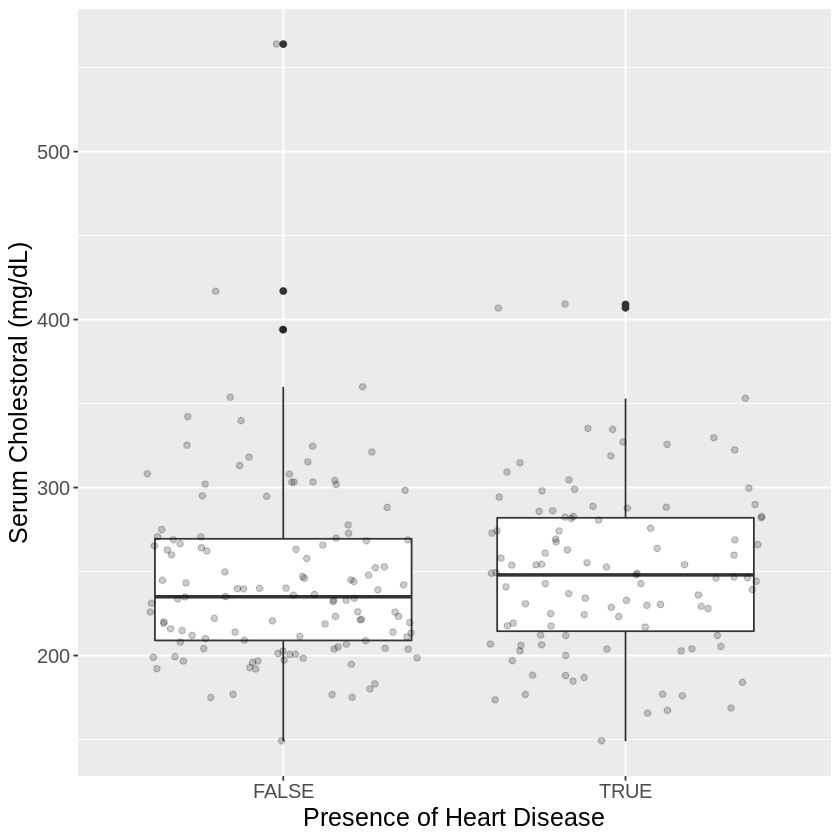

In [46]:
chol_summary_plot <- cleveland_training |>
    ggplot(aes(x = presence, y = chol))+
        geom_boxplot()+
        geom_point(position = "jitter", alpha = 0.2) +
        labs(x = "Presence of Heart Disease", y = "Serum Cholestoral (mg/dL)") +
        theme(text = element_text(size = 15))

chol_summary_plot

People who does not have presence of heart disease tend to have slightly less cholestoral in their blood than people with heart disease.

### Fasting Blood Sugar

In [47]:
#pull the number of instances of each type of heart disease
disease_count <- c(123, 103)

fbs_summary <- cleveland_training |>
    group_by(presence, fbs) |>
    summarize(count = n()) 

fbs_lower_than_proportion <- fbs_summary |>
    filter(fbs == 0) |> 
    bind_cols(type_count = disease_count) |>
    mutate(lower_than_proportion = count / type_count) |>
    select(presence, lower_than_proportion)

fbs_summary
fbs_lower_than_proportion

`summarise()` has grouped output by 'presence'. You can override using the
`.groups` argument.


presence,fbs,count
<fct>,<fct>,<int>
FALSE,0,107
FALSE,1,16
TRUE,0,88
TRUE,1,15


presence,lower_than_proportion
<fct>,<dbl>
FALSE,0.8699187
TRUE,0.8543689


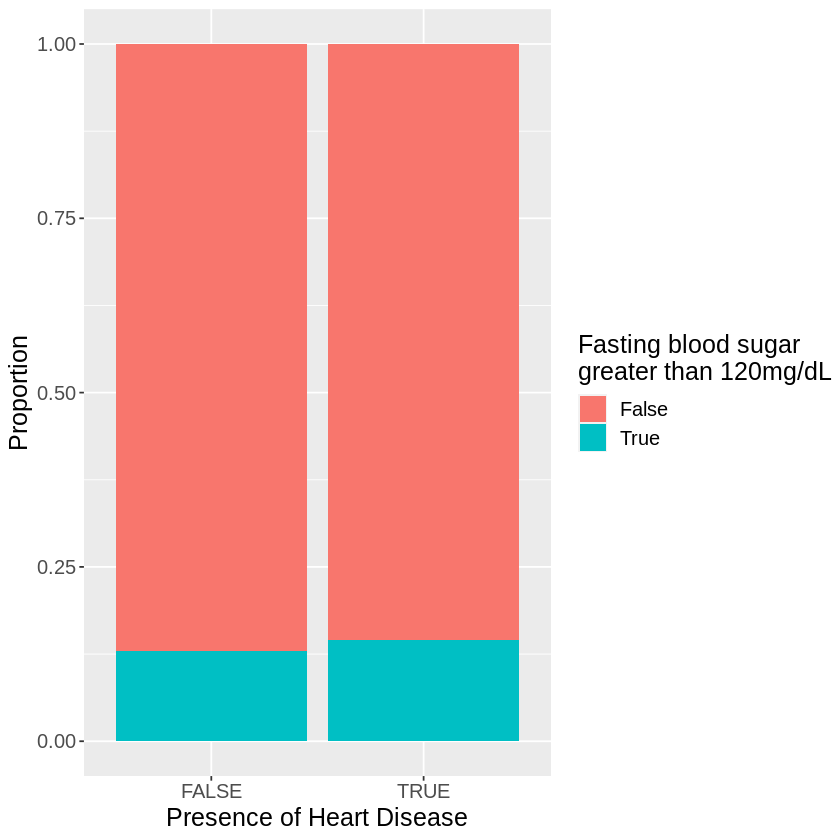

In [48]:
fbs_summary_plot <- cleveland_training |>
    ggplot(aes(x = presence, fill = fbs)) +
    geom_bar(position = "fill") +
    labs(x = "Presence of Heart Disease", y = "Proportion", fill = "Fasting blood sugar \ngreater than 120mg/dL") +
    scale_fill_discrete(labels = c("False", "True")) +
    theme(text = element_text(size = 15))
fbs_summary_plot

### Resting electrocardiographic

In [49]:
restecg_summary <- cleveland_training |>
    group_by(presence, restecg) |>
    summarize(count = n()) |>
    filter(restecg == 0) |> 
    bind_cols(type_count = disease_count) |>
    mutate(normal_proportion = count / type_count) |>
    select(presence, normal_proportion)
restecg_summary

`summarise()` has grouped output by 'presence'. You can override using the
`.groups` argument.


presence,normal_proportion
<fct>,<dbl>
FALSE,0.5934959
TRUE,0.4174757


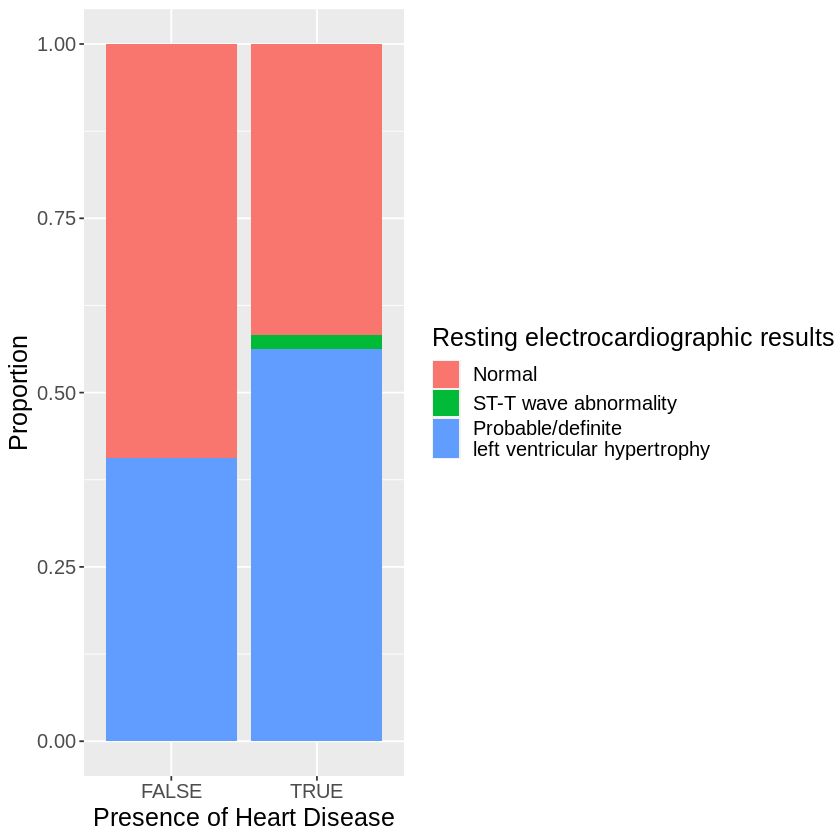

In [50]:
restecg_summary_plot <- cleveland_training |>
    ggplot(aes(x = presence, fill = restecg)) +
    geom_bar(position = "fill") +
    labs(x = "Presence of Heart Disease", y = "Proportion", fill = "Resting electrocardiographic results") +
    scale_fill_discrete(labels = c("Normal", "ST-T wave abnormality", "Probable/definite \nleft ventricular hypertrophy")) +
    theme(text = element_text(size = 15))
restecg_summary_plot

### Maximum Heart Rate

In [51]:
average_thalach <- cleveland_training |>
    summarize(average_thalach = mean(thalach))
average_thalach

average_thalach
<dbl>
149.4867


The average maximum heart rate achieved for this dataset is 149.5 *bpm*.

In [52]:
average_thalach_by_type <- cleveland_training |>
    group_by(presence) |>
    summarize(average_thalach = mean(thalach))
average_thalach_by_type

presence,average_thalach
<fct>,<dbl>
FALSE,158.4309
TRUE,138.8058


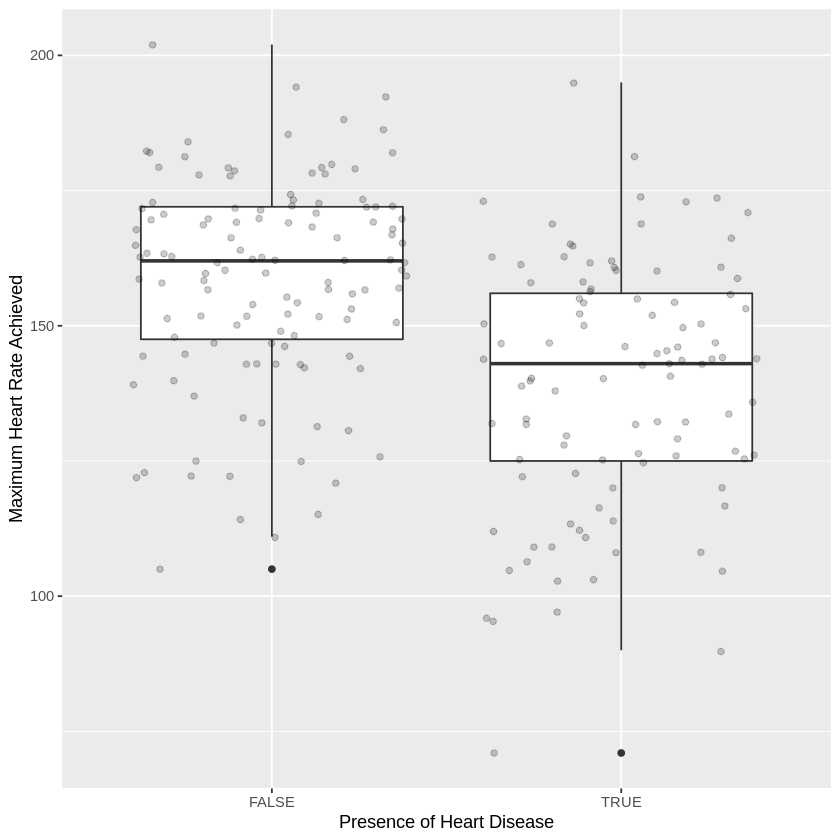

In [53]:
thalach_summary_plot <- cleveland_training |>
    ggplot(aes(x = presence, y = thalach)) +
    geom_boxplot() +
    geom_point(position = "jitter", alpha = 0.2) +
    labs(x = "Presence of Heart Disease", y = "Maximum Heart Rate Achieved")

thalach_summary_plot

People who have presence of heart disease tend to have lower maximum heart rate achieved compared to people who don't.

### Exercise Induced Angina

In [54]:
exang_summary <- cleveland_training |>
    group_by(presence, exang) |>
    summarize(count = n()) 

exang_proportion <- exang_summary |>
    filter(exang == 0) |> 
    bind_cols(type_count = disease_count) |>
    mutate(exang_proportion = count / type_count) |>
    select(presence, exang_proportion)

exang_summary
exang_proportion

`summarise()` has grouped output by 'presence'. You can override using the
`.groups` argument.


presence,exang,count
<fct>,<fct>,<int>
FALSE,0,103
FALSE,1,20
TRUE,0,50
TRUE,1,53


presence,exang_proportion
<fct>,<dbl>
FALSE,0.8373984
TRUE,0.4854369


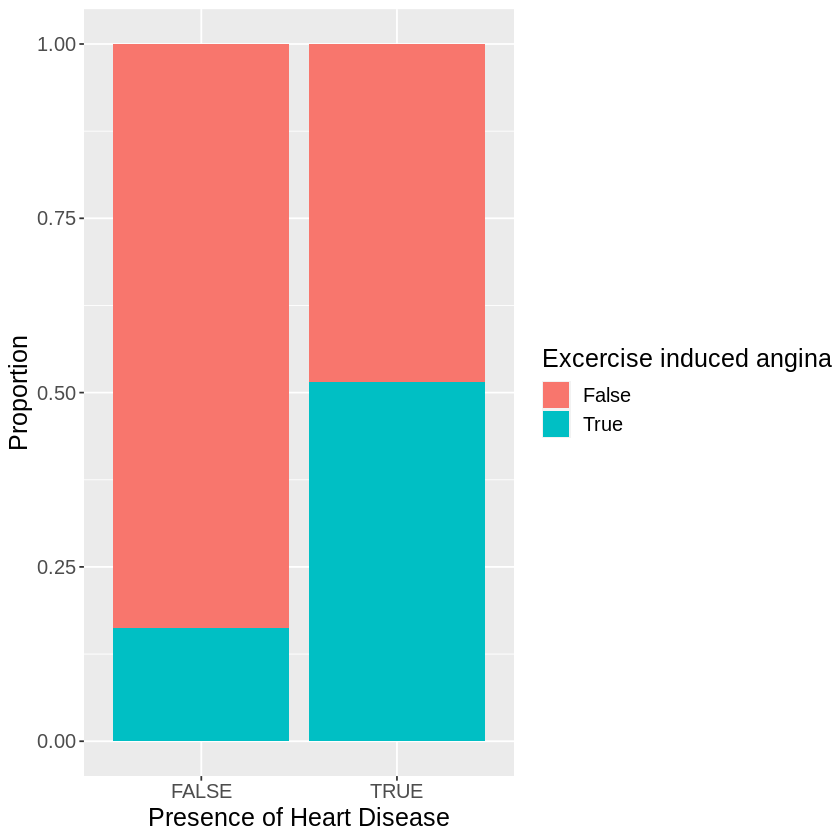

In [55]:
exang_summary_plot <- cleveland_training |>
    ggplot(aes(x = presence, fill = exang)) +
    geom_bar(position = "fill") +
    labs(x = "Presence of Heart Disease", y = "Proportion", fill = "Excercise induced angina") +
    scale_fill_discrete(labels = c("False", "True")) +
    theme(text = element_text(size = 15))
exang_summary_plot

### ST Depression

In [56]:
average_oldpeak <- cleveland_training |>
    summarize(average_oldpeak = mean(oldpeak))
average_oldpeak

average_oldpeak
<dbl>
1.033186


In [57]:
average_oldpeak_by_type <- cleveland_training |>
    group_by(presence) |>
    summarize(average_oldpeak = mean(oldpeak))
average_oldpeak_by_type

presence,average_oldpeak
<fct>,<dbl>
FALSE,0.5910569
TRUE,1.5611650


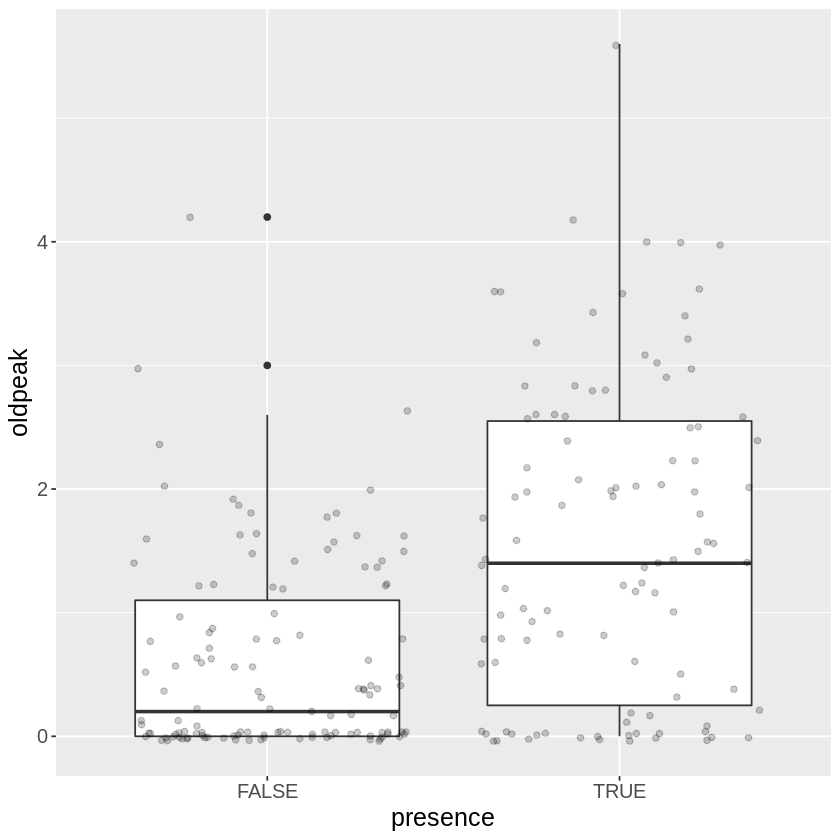

In [58]:
oldpeak_summary_plot <- cleveland_training |>
    ggplot(aes(x = presence, y = oldpeak)) +
    geom_boxplot() +
    geom_point(position = "jitter", alpha = 0.2) +
    theme(text = element_text(size = 15))

oldpeak_summary_plot

### Slope of the Peak Exercise ST Segment

In [59]:
slope_summary <- cleveland_training |>
    group_by(presence, slope) |>
    summarize(count = n()) 
slope_summary

`summarise()` has grouped output by 'presence'. You can override using the
`.groups` argument.


presence,slope,count
<fct>,<fct>,<int>
FALSE,1,81
FALSE,2,35
FALSE,3,7
TRUE,1,26
TRUE,2,68
TRUE,3,9


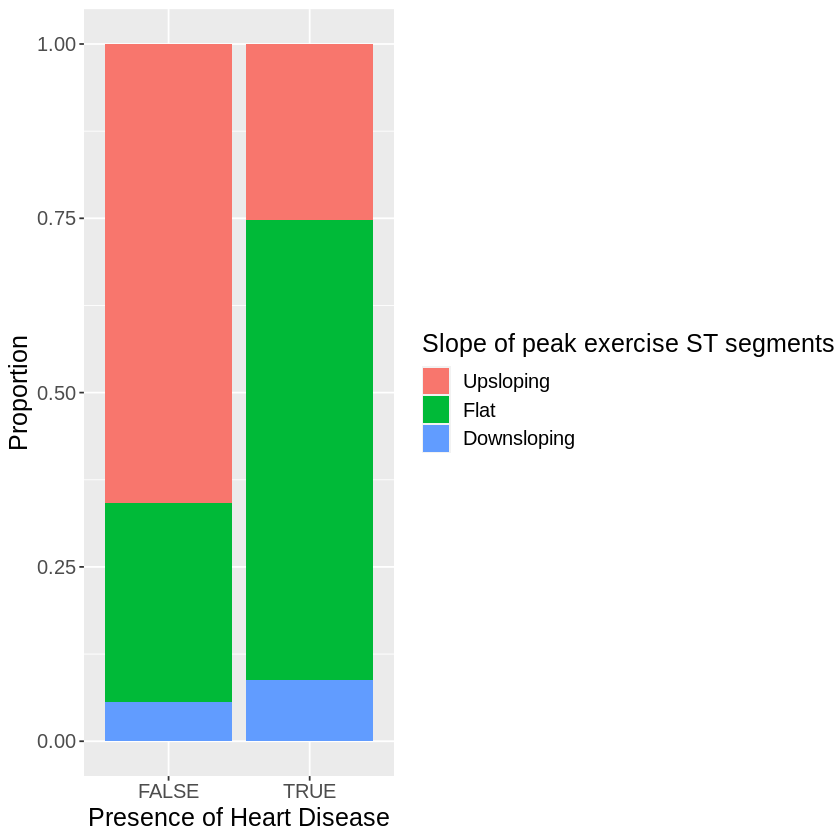

In [60]:
slope_summary_plot <- cleveland_training |>
    ggplot(aes(x = presence, fill = slope)) +
    geom_bar(position = "fill") +
    labs(x = "Presence of Heart Disease",y = "Proportion", fill = "Slope of peak exercise ST segments") +
    scale_fill_discrete(labels = c("Upsloping", "Flat", "Downsloping")) +
    theme(text = element_text(size = 15))
slope_summary_plot

### Number of major vessels colored by flourosopy

In [61]:
ca_summary <- cleveland_training |>
    filter(!is.na(ca)) |>
    group_by(presence, ca) |>
    summarize(count = n()) 

ca_summary

`summarise()` has grouped output by 'presence'. You can override using the
`.groups` argument.


presence,ca,count
<fct>,<int>,<int>
FALSE,0,95
FALSE,1,16
FALSE,2,6
FALSE,3,3
TRUE,0,36
TRUE,1,35
TRUE,2,21
TRUE,3,10


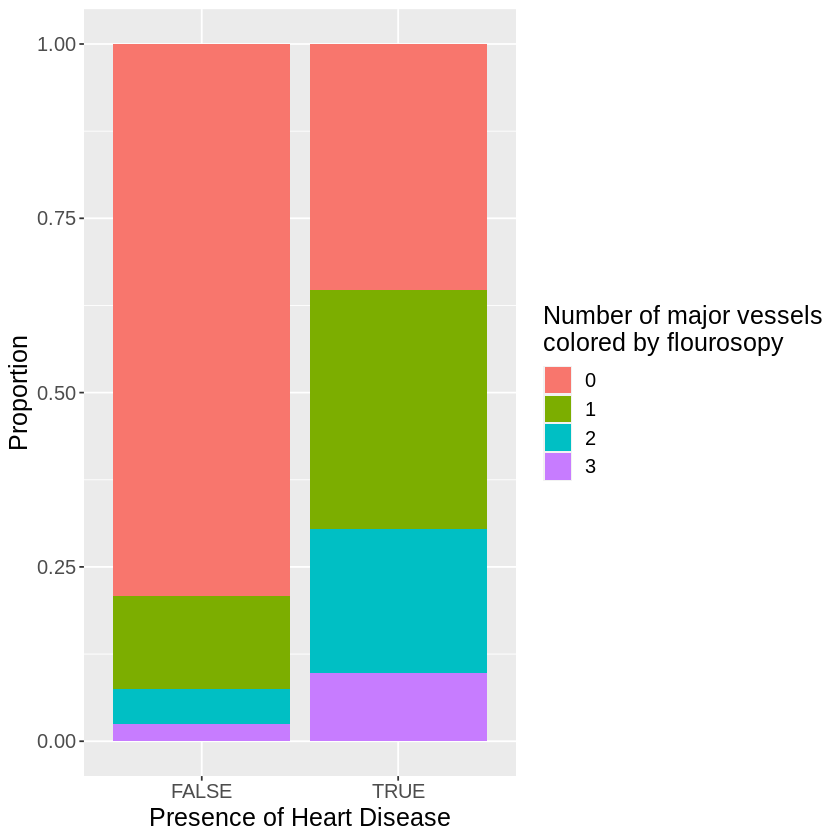

In [62]:
ca_summary_plot <- cleveland_training |>
    filter(!is.na(ca)) |>
    ggplot(aes(x = presence, fill = as.factor(ca))) +
    geom_bar(position = "fill") +
    labs(x = "Presence of Heart Disease", y = "Proportion",
         fill = "Number of major vessels \ncolored by flourosopy") +
    scale_fill_discrete(labels = c(0, 1, 2, 3)) +
    theme(text = element_text(size = 15))
ca_summary_plot

### Choosing Predictor Variables